# Loss Based Sampling

In this work I will try to implement and test Loss Based Sampling (LBS) and compare it with 'vanilla' training on whole dataset. The idea behind LBS is following:
- We train on whole dataset
- At first iteration we make forward pass on whole dataset -> compute loss -> take 80% of samples with the highest loss and use them for backward pass
- On second iteration we take those 80% of samples and do forward pass and again compute loss -> take 80% of samples with the highest loss and use them for backward pass and so on
- On every 5th iteration we start from the begining and train on whole dataset and repeat steps as described above.

For testing purposes I will use [MNIST](http://yann.lecun.com/exdb/mnist/) dataset and [LeNet5](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) architecture which was initially adapted for this dataset.

### Importing libraries and defining constants

In [1]:
import os
import random
import time
from datetime import datetime
from datetime import timedelta

import numpy as np

# To get torch.sort() working
# may affect performance on MPS
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader

In [2]:
# Defining config class
class CFG:
    num_classes = 10
    learning_rate = 0.001
    epochs = 120 #86
    lbs_fraq = 0.8 # Fraqtion from dataset to use for resampling during training
    seed = 42

# Setting device for PyTorch
if torch.cuda.is_available():
    CFG.device = torch.device('cuda')
elif torch.has_mps:
    CFG.device = torch.device('mps')
    # Works unstable on MPS, so using
    # CPU for training
    CFG.device = torch.device('cpu')
else:
    CFG.device = torch.device('cpu')


print(f'Using {CFG.device} device')

# Seed everything
def seed_everything(seed = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG.seed)

Using cpu device


### Loading the data

In [3]:
class DatasetWrapperIdx(Dataset):
    '''
    Custom class to get indicies while iterating
    over dataset
    '''
    def __init__(self, input_data):
        self.data = input_data

    def __getitem__(self, index):
        data, target = self.data[index]

        return index, data, target

    def __len__(self):
        return len(self.data)


In [4]:
# Transform image for LeNet input requirements and convert to grayscale
# because according to paper it performs better on them
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.Grayscale(),
                                transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transform,
                                           download = True)

train_dataset = DatasetWrapperIdx(train_dataset)

valid_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transform,
                                          download=True)
valid_dataset = DatasetWrapperIdx(valid_dataset)


### Let's look at the data

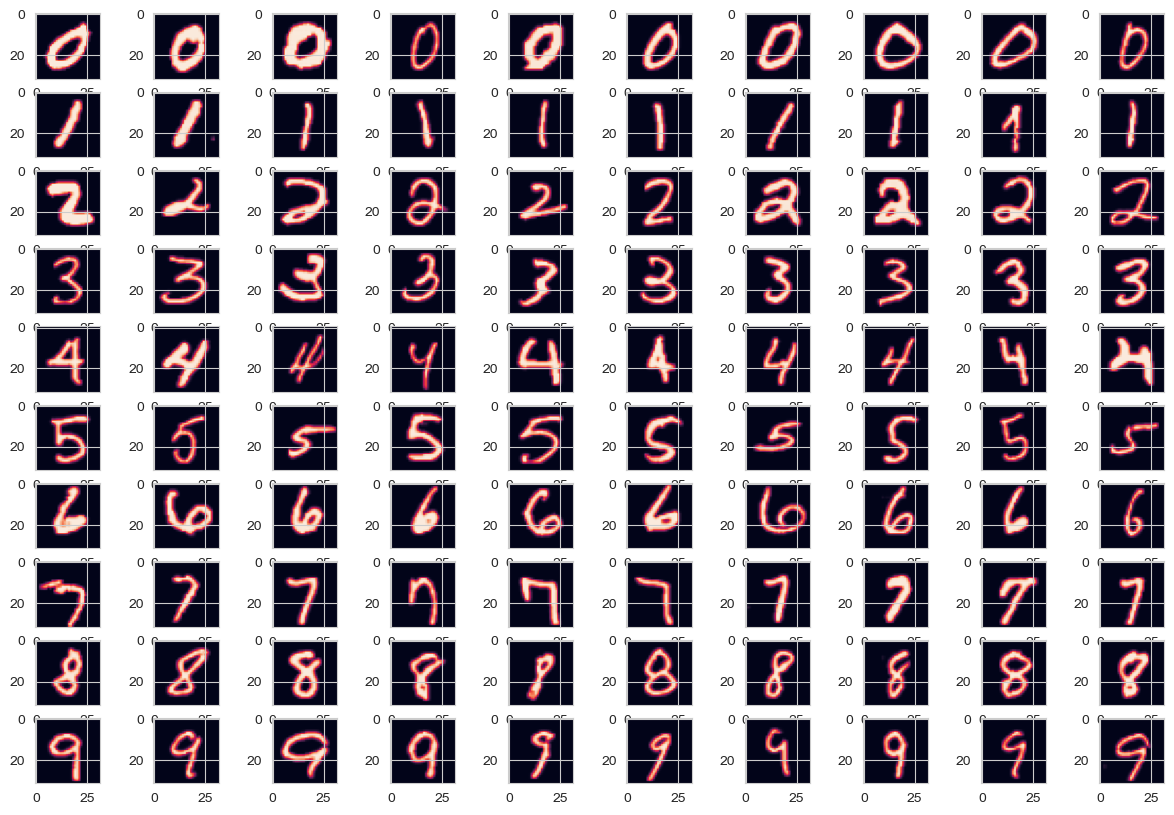

In [5]:
import matplotlib.pyplot as plt

num_cols = 10

fig, axs = plt.subplots(CFG.num_classes, num_cols, figsize=(15, 10))

for cls in range(CFG.num_classes):
    # Get indicies for specific class
    cls_indicies = (train_dataset.data.targets == cls).nonzero(as_tuple=True)[0]
    # Get random samples for given class
    p = torch.ones(cls_indicies.shape[0]) / cls_indicies.shape[0]
    rand_indicies = torch.multinomial(p, num_samples=num_cols, replacement=False)

    for col, idx in enumerate(cls_indicies[rand_indicies]):
        axs[cls][col].imshow(train_dataset.data[idx][0][0]);

We can see that images from each class have quite unique shapes and recognisible patterns, so our simple model can potentially recognize them.

### Model and helper functions

In [6]:
class LeNet5(nn.Module):
    '''
    LeNet5 architecture
    '''
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc1 = nn.Linear(400, 120)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(84, CFG.num_classes)

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        probs = F.softmax(out, dim=1)
        return out, probs

In [7]:
def accuracy(probs, labels):
    '''
    Computes accuracy for given probabilities and labels
    :param probs: Probabilities from PyTorch model
    :param labels: Target labels
    :return: Accuracy score from 0 to 1
    '''
    _, pred_labels = torch.max(probs, 1)
    labels = labels
    return torch.sum(pred_labels == labels) / len(labels)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    :param elapsed: Time in seconds
    :return: String in format hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(timedelta(seconds=elapsed_rounded))

def plot_learning_results(first_data, second_data,
                          first_type='Training Loss', second_type='Validation Loss',
                          type='Loss',
                          title = '', ax=None):
    '''
    Plots curves based on 2 lists of datapoints per epoch.
    Based on type parameter can be used to plot Loss or Metric curves.
    :param first_data: Loss or metric values per epoch
    :param second_data: Loss or metric values per epoch
    :param type: Type of curve. Can be 'Loss' or Metric
    :param title: Title for graph
    :param ax: Matplotlib ax value to plot on
    '''
    first_data = np.array(first_data)
    second_data = np.array(second_data)

    if ax is None:
        fig, ax = plt.subplots(figsize = (15, 10))

    ax.plot(first_data, color='blue', label=f'{first_type}')
    ax.plot(second_data, color='orange', label=f'{second_type}')
    ax.set(title=f"{title}",
           xlabel='Epoch',
           ylabel=f'{type}')
    ax.legend()

def create_model(num_classes, learning_rate, device):
    '''
    Creates PyTorch LeNet5 model, optimizer and loss function
    :param num_classes: Number of output classes
    :param learning_rate: Learning rate
    :param device: Device to use for training
    :return:
        model,
        optimizer,
        criterion
    '''
    model = LeNet5(num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Using reduction='none' to get individual loss for each sample
    criterion = nn.CrossEntropyLoss(reduction='none')

    return model, optimizer, criterion


def valid_fn(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop.
    :param valid_loader: DataLoader with validation data
    :param model: Model to validate
    :param criterion: Loss function
    :param device: Device to use for evaluation
    :return:
        model: Model used for validation
        epoch_loss: Loss computed on validation dataset
        epoch_acc: Accuracy computed on validation dataset
    '''

    model.eval()
    total_loss = 0
    total_accuracy = 0

    for idx, X, y_true in valid_loader:

        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass
        y_pred, y_prob = model(X)
        loss_each = criterion(y_pred, y_true)
        loss_all = torch.mean(loss_each)

        total_loss += loss_all.item()

        total_accuracy += accuracy(y_prob, y_true)

    epoch_loss = total_loss / len(valid_loader)
    epoch_acc = total_accuracy / len(valid_loader)

    return model, epoch_loss, epoch_acc

def train_loop(model, optimizer, criterion, train_dataset, valid_dataset, epochs, device,
               print_freq=1, lbs=False, lbs_freq=5, lbs_fraq = 0.8):
    '''
    Function defining the model and the entire training loop
    :param model: Model to train
    :param optimizer: Optimization method for model wheigts
    :param criterion: Loss function
    :param train_dataset: Training set (PyTorch Dataset)
    :param valid_dataset: Validation set (PyTorch Dataset)
    :param epochs: Number of epochs
    :param device: Device to use
    :param print_freq: Print frequency in epochs to print learning process state
    :param lbs: Use LBS for training
    :param lbs_freq: How often reset LBS process and start traing on whole dataset
    :param lbs_fraq: Fraction of dataset to use for next iteration during LBS
    :return:
        model: Model used for training
        optimizer: Optimizer used for training
        (train_losses, valid_losses): Training and validation losses per epoch
        (train_accs, valid_accs): Training and validation accuracy scores per epoch
    '''
    # Set lists for storing metrics
    train_losses = []
    valid_losses = []

    train_accs = []
    valid_accs = []

    # Initializing ids for the dataset
    # Note: Not allowed to use subsamples from
    # original dataset
    sample_ids = torch.arange(0, len(train_dataset)).to(device)
    chosen_samp_ids = sample_ids

    # dataset_subset = data_utils.Subset(train_dataset, sample_ids)
    train_loader = DataLoader(dataset = train_dataset,
                              batch_size = len(train_dataset),
                              shuffle = True)

    valid_loader = DataLoader(dataset = valid_dataset,
                              batch_size = len(valid_dataset),
                              shuffle = True)

    start = time.time()

    # Train model
    for epoch in range(epochs):
        print(f"Running {epoch} epoch...")
        model.train()

        # If we are in lbs mode
        # and not on first epoch
        if lbs:
            if epoch % (lbs_freq - 1) == 0:
                # Using whole dataset every lbs_freq's epoch
                sample_ids = torch.arange(0, len(train_dataset)).to(device)
            else:
                # Using sampled ids
                sample_ids = chosen_samp_ids

            train_loader = DataLoader(
                train_dataset, batch_size=len(sample_ids),
                sampler =  torch.utils.data.sampler.SubsetRandomSampler(sample_ids)
            )


        for ids, X, y_true in train_loader:
            optimizer.zero_grad()

            ids = ids.to(device)

            X = X.to(device)

            y_true = y_true.to(device)

            # Forward pass
            y_pred, y_prob = model(X)

            loss_each = criterion(y_pred, y_true)

            if lbs:
                print(f'Number of samples used: {len(ids)}')
                # Sorting losses and getting indicies for highest
                _, idx_sorted = loss_each.sort(descending=True)
                num_chosen_samps = int(lbs_fraq * len(ids))
                idx_sorted = idx_sorted[:num_chosen_samps]
                chosen_samp_ids = ids[idx_sorted]
                loss_each = loss_each[idx_sorted]

            loss_all = torch.mean(loss_each)

            # Backward pass
            loss_all.backward()
            optimizer.step()

            train_loss = loss_all.item()
            train_acc = accuracy(y_prob, y_true)

        train_losses.append(train_loss)
        train_accs.append(float(train_acc.cpu()))

        # Validation
        with torch.no_grad():
            model, valid_loss, valid_acc = valid_fn(valid_loader, model,
                                                    criterion, CFG.device)
            valid_losses.append(valid_loss)
            valid_accs.append(float(valid_acc.cpu()))

        if epoch % print_freq == (print_freq - 1):

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    traing_took_time = format_time(time.time() - start)
    print(f'Training completed and took: {traing_took_time}')

    return model, optimizer, (train_losses, valid_losses), (train_accs, valid_accs)

### Training

Training with Loss Based Sampling

In [8]:
model, optimizer, criterion = create_model(CFG.num_classes, CFG.learning_rate, CFG.device)
_, _, (lbs_train_losses, lbs_valid_losses), (lbs_train_accs, lbs_valid_accs) = train_loop(model, optimizer, criterion,
                                                        train_dataset, valid_dataset, CFG.epochs, CFG.device,
                                                        lbs=True, lbs_fraq=CFG.lbs_fraq)

Running 0 epoch...
Number of samples used: 60000
07:02:51 --- Epoch: 0	Train loss: 2.3317	Valid loss: 2.2985	Train accuracy: 13.23	Valid accuracy: 13.64
Running 1 epoch...
Number of samples used: 48000
07:03:04 --- Epoch: 1	Train loss: 2.2782	Valid loss: 2.2921	Train accuracy: 26.18	Valid accuracy: 11.18
Running 2 epoch...
Number of samples used: 38400
07:03:14 --- Epoch: 2	Train loss: 2.2475	Valid loss: 2.2854	Train accuracy: 29.74	Valid accuracy: 14.25
Running 3 epoch...
Number of samples used: 30720
07:03:22 --- Epoch: 3	Train loss: 2.2175	Valid loss: 2.2775	Train accuracy: 36.87	Valid accuracy: 19.91
Running 4 epoch...
Number of samples used: 60000
07:03:38 --- Epoch: 4	Train loss: 2.2145	Valid loss: 2.2672	Train accuracy: 38.35	Valid accuracy: 20.63
Running 5 epoch...
Number of samples used: 48000
07:03:50 --- Epoch: 5	Train loss: 2.2196	Valid loss: 2.2551	Train accuracy: 32.25	Valid accuracy: 25.17
Running 6 epoch...
Number of samples used: 38400
07:04:00 --- Epoch: 6	Train loss:

Training without Loss Based Sampling

In [9]:
model, optimizer, criterion = create_model(CFG.num_classes, CFG.learning_rate, CFG.device)
_, _, (train_losses, valid_losses), (train_accs, valid_accs) = train_loop(model, optimizer, criterion,
                                                        train_dataset, valid_dataset, CFG.epochs, CFG.device,
                                                        lbs=False)

Running 0 epoch...
07:25:56 --- Epoch: 0	Train loss: 2.3207	Valid loss: 2.3018	Train accuracy: 9.25	Valid accuracy: 10.09
Running 1 epoch...
07:26:12 --- Epoch: 1	Train loss: 2.2619	Valid loss: 2.2984	Train accuracy: 28.49	Valid accuracy: 10.09
Running 2 epoch...
07:26:27 --- Epoch: 2	Train loss: 2.2150	Valid loss: 2.2939	Train accuracy: 38.17	Valid accuracy: 10.09
Running 3 epoch...
07:26:42 --- Epoch: 3	Train loss: 2.1630	Valid loss: 2.2874	Train accuracy: 46.07	Valid accuracy: 10.66
Running 4 epoch...
07:26:57 --- Epoch: 4	Train loss: 2.1003	Valid loss: 2.2784	Train accuracy: 52.59	Valid accuracy: 24.61
Running 5 epoch...
07:27:12 --- Epoch: 5	Train loss: 2.0286	Valid loss: 2.2666	Train accuracy: 56.30	Valid accuracy: 24.74
Running 6 epoch...
07:27:27 --- Epoch: 6	Train loss: 1.9503	Valid loss: 2.2521	Train accuracy: 58.54	Valid accuracy: 21.54
Running 7 epoch...
07:27:42 --- Epoch: 7	Train loss: 1.8648	Valid loss: 2.2347	Train accuracy: 60.34	Valid accuracy: 17.14
Running 8 epoch..

What we can see is that training with LBS takes almost 1.5 times less time without significant effect on validation accuracy. Training with LBS gives roughly 0.2 percent better score.

Plotting learning curves

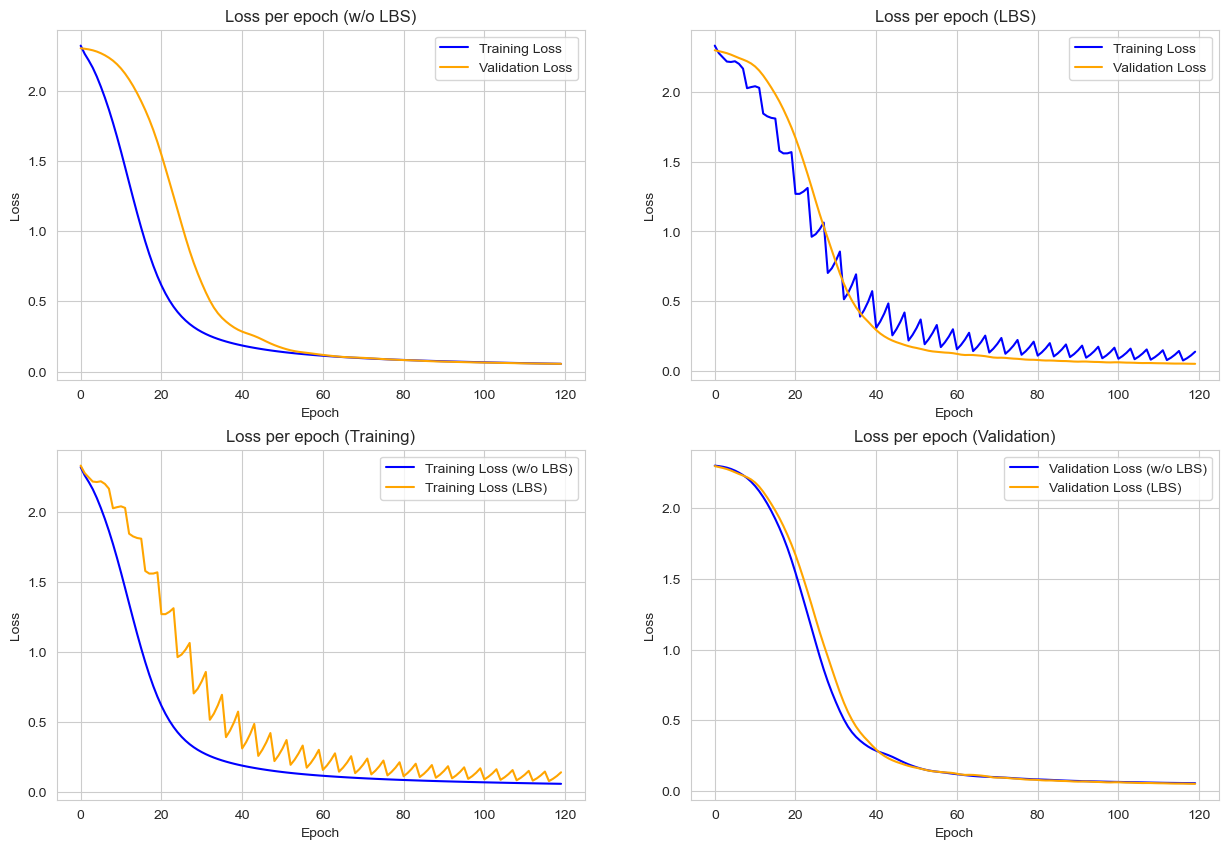

In [12]:
fig, axs = plt.subplots(2,2, figsize=(15, 10))

plot_learning_results(train_losses, valid_losses, type='Loss', title='Loss per epoch (w/o LBS)', ax=axs[0][0])
plot_learning_results(lbs_train_losses, lbs_valid_losses, type='Loss', title = 'Loss per epoch (LBS)', ax=axs[0][1])

plot_learning_results(train_losses, lbs_train_losses, 'Training Loss (w/o LBS)', 'Training Loss (LBS)',
                      type='Loss', title='Loss per epoch (Training)', ax=axs[1][0])
plot_learning_results(valid_losses, lbs_valid_losses, 'Validation Loss (w/o LBS)', 'Validation Loss (LBS)',
                      type='Loss', title='Loss per epoch (Validation)', ax=axs[1][1])

From learning curves we can conclude that training without LBS goes to minima faster than training with LBS, but after 60th epoch there is no significant difference in behaviour of validation loss. There is also intresting thing regarding "zigzag" form of training loss curve, which happens due to selection of samples with the highest loss during training, therefore loss computed based on them is higher than loss on all samples. Less values of loss tend to lower overall loss.

Plotting accuracy per epoch curves

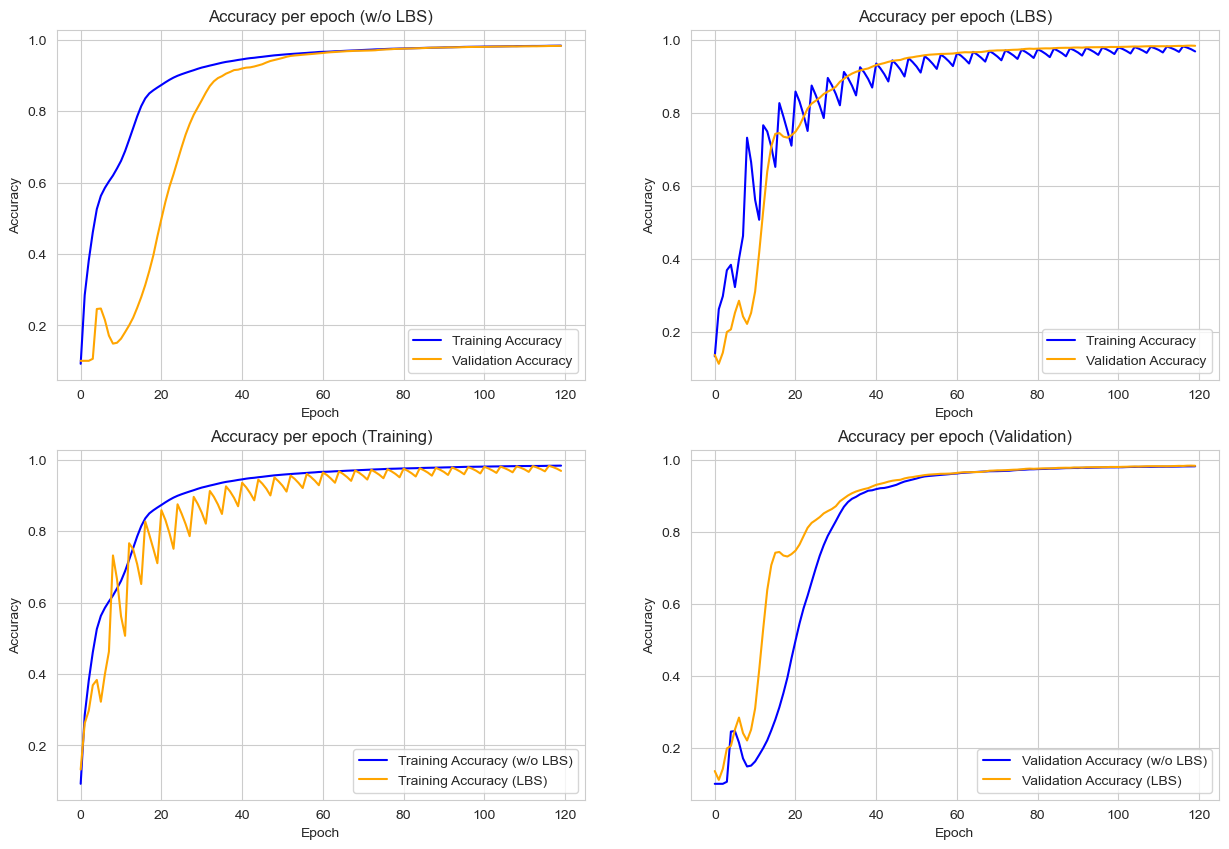

In [14]:
fig, axs = plt.subplots(2,2, figsize=(15, 10))

plot_learning_results(train_accs, valid_accs, 'Training Accuracy', 'Validation Accuracy',
                      type='Accuracy', title='Accuracy per epoch (w/o LBS)', ax=axs[0][0])
plot_learning_results(lbs_train_accs, lbs_valid_accs, 'Training Accuracy', 'Validation Accuracy',
                      type='Accuracy', title = 'Accuracy per epoch (LBS)', ax=axs[0][1])

plot_learning_results(train_accs, lbs_train_accs, 'Training Accuracy (w/o LBS)', 'Training Accuracy (LBS)',
                      type='Accuracy', title='Accuracy per epoch (Training)', ax=axs[1][0])
plot_learning_results(valid_accs, lbs_valid_accs, 'Validation Accuracy (w/o LBS)', 'Validation Accuracy (LBS)',
                      type='Accuracy', title='Accuracy per epoch (Validation)', ax=axs[1][1])

Here we see quite interesting picture on accuracy score on validation set, LBS training goes up significantly faster, but after 60th epoch behaviour of both curves is the same. This may happen due to training on most hard to predict samples and model is forced to learn some complex patterns faster so it is easier for model to generalize on whole validation set.

### Conclusion

In overall LBS is usefull technique to optimize training time (~1.5 times) and potentially improving target metric. Probably we can add more epochs to LBS training to get event better results, but for comparison to be more fair I used the same conditions for both approaches.